In [35]:
import pandas as pd
from constants import *
import numpy as np
import pandas as pd

In [36]:
PATH = "../"

PREDICTION = PATH + "runs/detect/predict/labels/"

# Set the MAP_VAL (50 for mAP50, 5095 for mAP50-95)
MAP_VAL = 50  # Change to 5095 for mAP50-95


In [37]:
# Read the content from the test.txt file
with open(PATH + TEST_TXT, 'r') as file:
    file_paths = file.read().splitlines()

# Process the paths to create files_true and files_pred
files_true = [PATH + path.replace("images", "labels").replace(".JPG", ".txt") for path in file_paths]
files_pred = [PREDICTION + path.split('/')[-1].replace(".JPG", ".txt") for path in file_paths]

# Create DataFrames from the processed paths
data_true = {'true_values': files_true}
data_pred = {'predicted_values': files_pred}

df_true = pd.DataFrame(data_true)
df_pred = pd.DataFrame(data_pred)

In [38]:
# Read the paths to true and predicted values
files_true = pd.read_csv(PATH + TEST_TXT, header=None)
files_pred = pd.read_csv(PATH + TEST_TXT, header=None)

In [39]:
# Process the paths to create the lists of true and predicted values
true_values = []
for file_true in files_true[0]:
    try:
        file = PATH + file_true.replace("images", "labels").replace(".JPG", ".txt")
        with open(file, 'r') as f:
            lines = f.read().splitlines()
            bboxes = [[int(line.split()[0])] for line in lines]  # Extract class only
            true_values.append(bboxes)
    except FileNotFoundError:
        true_values.append([])  # No bounding boxes, treated as background (class 15)

In [40]:
predicted_values = []
for file_pred in files_pred[0]:
    try:
        file = PREDICTION + file_pred.split('/')[-1].replace(".JPG", ".txt")
        with open(file, 'r') as f:
            lines = f.read().splitlines()
            bboxes = [[int(line.split()[0])] for line in lines]  # Extract class only
            predicted_values.append(bboxes)
    except FileNotFoundError:
        predicted_values.append([])  # No bounding boxes, treated as background (class 15)

In [41]:
import numpy as np
import pandas as pd

# Set the MAP_VAL (50 for mAP50, 5095 for mAP50-95)
MAP_VAL = 50  # Change to 5095 for mAP50-95

# Define the calculate_iou function
def calculate_iou(bbox1, bbox2):
    # Calculate intersection coordinates
    x_min = max(bbox1[1] - bbox1[3] / 2, bbox2[1] - bbox2[3] / 2)
    x_max = min(bbox1[1] + bbox1[3] / 2, bbox2[1] + bbox2[3] / 2)
    y_min = max(bbox1[2] - bbox1[4] / 2, bbox2[2] - bbox2[4] / 2)
    y_max = min(bbox1[2] + bbox1[4] / 2, bbox2[2] + bbox2[4] / 2)
    
    # Calculate intersection area
    intersection_area = max(0, x_max - x_min) * max(0, y_max - y_min)
    
    # Calculate union area
    bbox1_area = bbox1[3] * bbox1[4]
    bbox2_area = bbox2[3] * bbox2[4]
    union_area = bbox1_area + bbox2_area - intersection_area
    
    # Calculate IoU
    iou = intersection_area / union_area
    return iou

# Read the paths to true and predicted values
files_true = pd.read_csv(PATH + TEST_TXT, header=None)
files_pred = pd.read_csv(PATH + TEST_TXT, header=None)

# Process the paths to create the lists of true and predicted values
true_values = []
for file_true in files_true[0]:
    try:
        file = PATH + file_true.replace("images", "labels").replace(".JPG", ".txt")
        with open(file, 'r') as f:
            lines = f.read().splitlines()
            bboxes = [[int(line.split()[0]), float(line.split()[1]), float(line.split()[2]),
                       float(line.split()[3]), float(line.split()[4])] for line in lines]  # Extract class and bounding box coordinates
            true_values.append(bboxes)
    except FileNotFoundError:
        true_values.append([])  # No bounding boxes, treated as background (class 15)

predicted_values = []
for file_pred in files_pred[0]:
    try:
        file = PREDICTION + file_pred.split('/')[-1].replace(".JPG", ".txt")
        with open(file, 'r') as f:
            lines = f.read().splitlines()
            bboxes = [[int(line.split()[0]), float(line.split()[1]), float(line.split()[2]),
                       float(line.split()[3]), float(line.split()[4])] for line in lines]  # Extract class and bounding box coordinates
            predicted_values.append(bboxes)
    except FileNotFoundError:
        predicted_values.append([])  # No bounding boxes, treated as background (class 15)

# Calculate confusion matrix based on chosen mAP criteria
num_classes = 16  # Including background class
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

for idx,_ in enumerate(true_values):
    true_bboxes = true_values[idx]
    pred_bboxes = predicted_values[idx]
    true_classes = [bbox[0] for bbox in true_bboxes]
    pred_classes = [bbox[0] for bbox in pred_bboxes]

    for true_bbox in true_bboxes:
        for pred_bbox in pred_bboxes:
            true_class = int(true_bbox[0])
            pred_class = int(pred_bbox[0])
            iou = calculate_iou(true_bbox, pred_bbox)
            if iou >= MAP_VAL / 100:
                if MAP_VAL == 50:
                    # Use mAP50 criteria
                    conf_matrix[true_class, pred_class] += 1
                elif MAP_VAL == 5095:
                    # Use mAP50-95 criteria
                    conf_matrix[true_class, pred_class] += 1

# Print the confusion matrix
#print(conf_matrix)


[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 241   0   0   0   0   5   0   6   0   0   0   2   0   3   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   6   0   0   0   0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   7   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0 160   0   0   0   0   0  30   1   0   0]
 [  0   0   0   0   0   0   0   1   0   0   0   0   0   1   0   0]
 [  0  14   0   0   0   0   0   0 407   0   0   0   6   0   3   0]
 [  0   2   0   0   0   0   0   0   2 595   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   3   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   3   0]
 [  0   0   0   0   0   0   3   0   1   0   0   0 265   2   2   0]
 [  0   0   0   3   0   0   2   1   0   0   3   0   4 299   7   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   2 213 

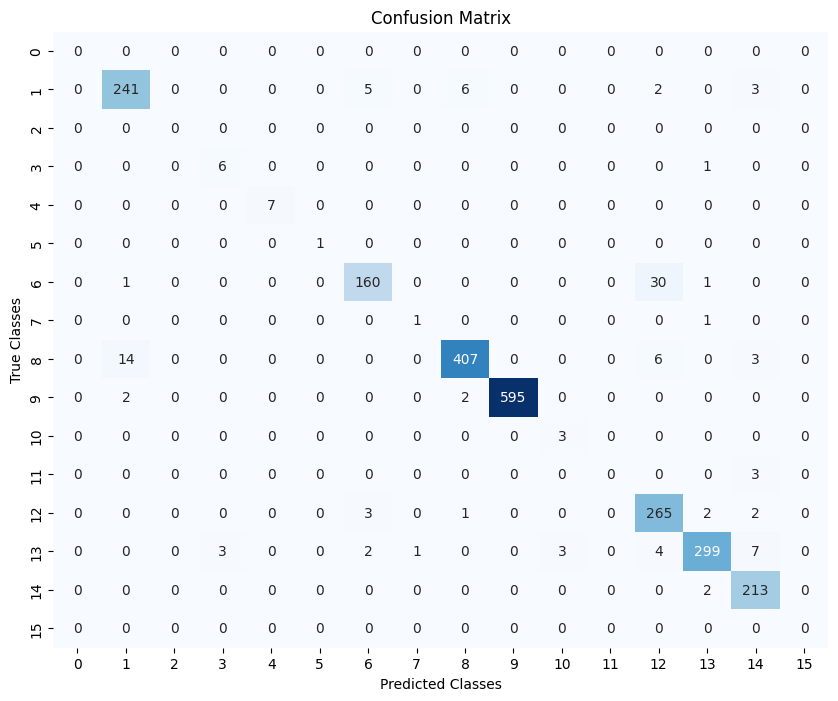

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.title("Confusion Matrix")
plt.show()

/tmp/ipykernel_1179037/725127588.py:4: RuntimeWarning: invalid value encountered in divide
  normalized_matrix = conf_matrix / col_sum


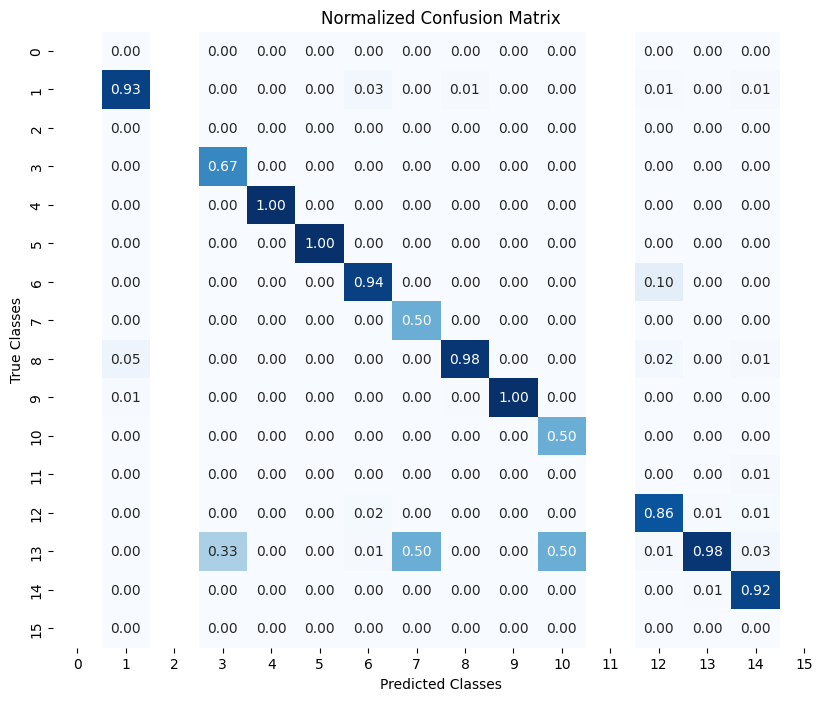

In [46]:
# Normalize the confusion matrix by column
def normalize_conf_matrix(conf_matrix):
    col_sum = np.sum(conf_matrix, axis=0)
    normalized_matrix = conf_matrix / col_sum
    return normalized_matrix

# Print the normalized confusion matrix
normalized_conf_matrix = normalize_conf_matrix(conf_matrix)
#print(normalized_conf_matrix)

# Visualize the normalized confusion matrix using colors
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_conf_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.title("Normalized Confusion Matrix")
plt.show()